In [ ]:
# Install dependencies
!pip install swig
!pip install gymnasium[box2d]
!pip install torch

import numpy as np
import torch
import random
import gymnasium as gym
from collections import deque
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
import time
import matplotlib.pyplot as plt

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.9/1.9 MB 13.8 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 953.9/953.9 kB 13.4 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 374.4/374.4 kB 24.0 MB/s eta 0:00:00
  Preparing metadata (setup.py) ... done
  Created wheel for box2d-py: filename=box2d_py-2.3.5-cp310-cp310-linux_x86_64.whl size=2376096 sha256=8b0a6d5511826495911a377659ad7df2017a657682e63f2ff5f8246699e23c5c
  Stored in directory: /root/.cache/pip/wheels/db/8f/6a/eaaadf056fba10a98d986f6dce954e6201ba3126926fc5ad9e
Successfully built box2d-py
  Using cached nvidia_cuda_nvrtc_cu12-12.1.105-py3-none-manylinux1_x86_64.whl (23.7 MB)
  Using cached nvidia_cuda_runtime_cu12-12.1.105-py3-none-manylinux1_x86_64.whl (823 kB)
  Using cached nvidia_cuda_cupti_cu12-12.1.105-py3-none-manylinux1_x86_64.whl (14.1 MB)
  Using cached nvidia_cudnn_cu12-8.9.2.26-py3-none-manylinux1_x86_64.whl (731.7 MB)
  Using cached nvidia_cublas_cu12-12.1.3.1-py3-none-manylinux1

Episode 1/2, Total Reward: -200.00660975743335, Elapsed Time: 24.869447946548462
Episode 2/2, Total Reward: -102.05795751644236, Elapsed Time: 0.6603138446807861
Maximum Reward: -102.05795751644236


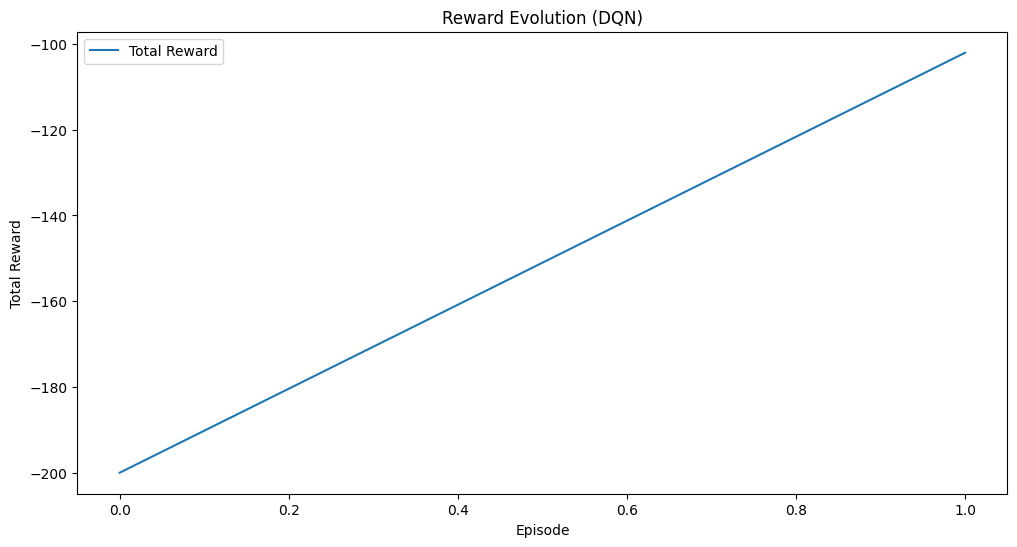

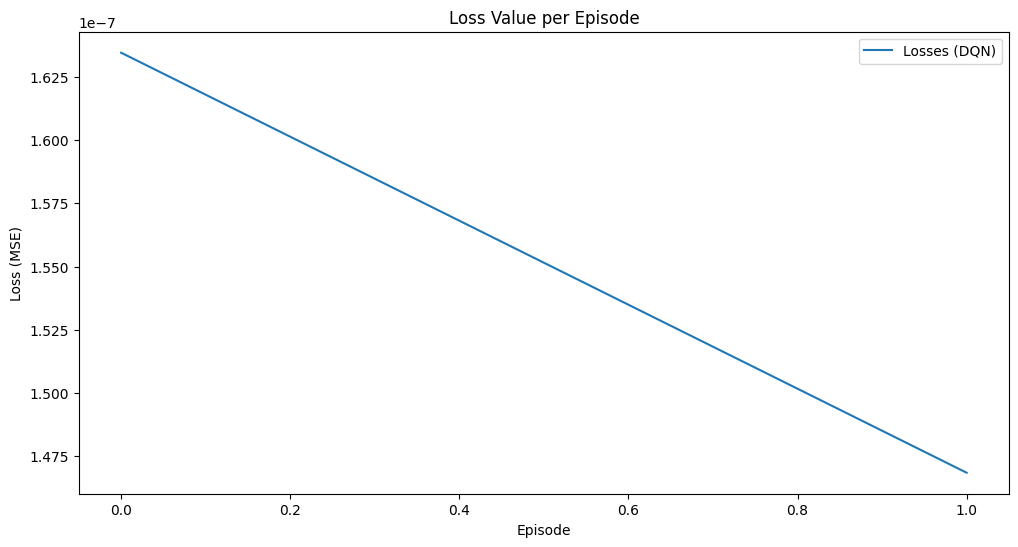

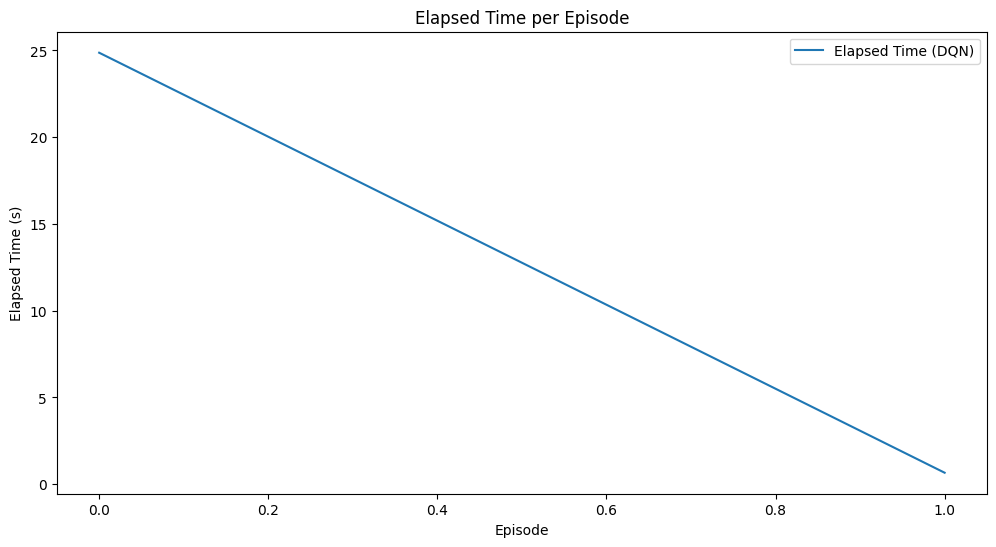

In [ ]:
# Definizione dell'ambiente
ENV = "BipedalWalker-v3"
DEVICE = torch.device("cuda" if torch.cuda.is_available() else "cpu")

# Hyperparameters
#agent
ACT_BUCKETS = 11
EPISODES = 1000
REWARD_THRESHOLD = -200
GAMMA = 0.9
ALPHA = 0.01
EPSILON_INIT = 1.0
EPSILON_DECAY = 0.999
EPSILON_MIN = 0.05
NORMALIZE = True

#experience replay
BATCH_SIZE = 64
MEM_SIZE = 1000000

#neural network
HIDDEN_SIZE = 512
LR = 1e-3

# Experience Replay
class ExperienceReplay:
    def __init__(self, buffer_size, batch_size=BATCH_SIZE):
        self.buffer = deque(maxlen=buffer_size)
        self.batch_size = batch_size

    def __len__(self):
        return len(self.buffer)

    def store_transition(self, state, action, reward, new_state, done):
        self.buffer.append((state, action, reward, new_state, done))

    def sample(self):
        sample = random.sample(self.buffer, self.batch_size)
        states, actions, rewards, next_states, dones = zip(*sample)

        # stack: turns a list of tensors into a tensor with a higher dimension
        states = torch.stack(states).to(DEVICE)
        next_states = torch.stack(next_states).to(DEVICE)

        # tensor: converts a list of values into a tensor
        actions = torch.tensor(actions).to(DEVICE)
        rewards = torch.tensor(rewards).float().to(DEVICE)
        dones = torch.tensor(dones).short().to(DEVICE)

        return states, actions, rewards, next_states, dones

class QNetwork(nn.Module):
    def __init__(self, state_dim, action_dim, hidden_size=HIDDEN_SIZE):
        super(QNetwork, self).__init__()
        self.fc1 = nn.Linear(state_dim, hidden_size)
        self.fc2 = nn.Linear(hidden_size, hidden_size)
        self.fc3 = nn.Linear(hidden_size, action_dim)

    def forward(self, state):
        x = F.relu(self.fc1(state))
        x = F.relu(self.fc2(x))
        x = self.fc3(x)
        return x

class Normalizer:
    def __init__(self, num_inputs):
        self.mean = np.zeros(num_inputs)
        self.m2 = np.zeros(num_inputs)
        self.count = 0

    # Welford's online algorithm for update using unbiased variance
    # more info: https://en.wikipedia.org/wiki/Algorithms_for_calculating_variance#Welford's_online_algorithm
    def update(self, x):
        self.count += 1
        old_mean = self.mean.copy()
        self.mean += (x - self.mean) / self.count
        self.m2 += (x - old_mean) * (x - self.mean)

    def normalize(self, x):
        eps = 1e-10
        mean = torch.tensor(self.mean).float().to(DEVICE)
        if self.count > 1:
            variance = self.m2 / (self.count - 1)
        else:
            variance = np.zeros_like(self.m2)
        stdev = torch.tensor(np.sqrt(variance) + eps).float().to(DEVICE)
        x = (x - mean) / (stdev)
        return x

# Agent
class Agent:
    def __init__(self, env, episodes=EPISODES, gamma=GAMMA, alpha=ALPHA, epsilon_init=EPSILON_INIT, epsilon_decay=EPSILON_DECAY, epsilon_min=EPSILON_MIN,
                 experience_replay_size=MEM_SIZE, act_buckets=ACT_BUCKETS, reward_threshold=REWARD_THRESHOLD, normalize=NORMALIZE, lr=LR, render=False):
        self.env = env
        self.episodes = episodes
        self.gamma = gamma
        self.alpha = alpha
        self.epsilon = epsilon_init
        self.epsilon_decay = epsilon_decay
        self.epsilon_min = epsilon_min
        self.memory = ExperienceReplay(experience_replay_size)
        self.action_buckets = act_buckets
        self.reward_threshold = reward_threshold
        self.render = render
        self.render_interval = 10

        self.model = QNetwork(env.observation_space.shape[0], self.action_buckets**env.action_space.shape[0]).to(DEVICE)
        # train the NN every "learning_frequency" steps
        self.learning_frequency = 1
        # weight_decay is the L2 regularization parameter in Adam
        self.optimizer = optim.Adam(self.model.parameters(), lr=lr)

        self.normalize = normalize
        # dynamic normalization computing mean and variance based on observations
        if normalize:
            self.normalizer = Normalizer(env.observation_space.shape[0])

    def discretize_action(self, action):
        discrete_action = np.round((action - self.env.action_space.low) / (self.env.action_space.high - self.env.action_space.low) * (self.action_buckets - 1)).astype(int)
        return tuple(discrete_action)

    def undiscretize_action(self, discrete_action):
        action = (discrete_action / (self.action_buckets - 1)) * (self.env.action_space.high - self.env.action_space.low) + self.env.action_space.low
        return tuple(action)

    def store(self, state, action, reward, new_state, done):
        self.memory.store_transition(state, action, reward, new_state, done)
        if len(self.memory) > BATCH_SIZE:
            self.learn()

    def updateDQN(self):
        states, actions, rewards, next_states, dones = self.memory.sample()
        if self.normalize:
            states = self.normalizer.normalize(states)
            next_states = self.normalizer.normalize(next_states)
        q_eval = self.model(states)
        q_next = self.model(next_states)

        # takes the q_value corresponding to the chosen action (for each sample)
        q_eval_actions = q_eval.gather(1, actions.unsqueeze(1)).squeeze(1)

        q_target = q_eval_actions * (1 - self.alpha) + self.alpha * (rewards + self.gamma * q_next.max(1)[0] * (1 - dones))

        loss = F.mse_loss(q_eval_actions, q_target)

        self.optimizer.zero_grad()
        loss.backward()
        self.optimizer.step()
        return loss.item()

    def choose_action(self, state):
        if random.random() < self.epsilon:
            discrete_action = np.random.randint(0, self.action_buckets**self.env.action_space.shape[0])
            return discrete_action
        else:
            with torch.no_grad():
                state = torch.tensor(state).float().to(DEVICE)
                if self.normalize:
                    state = self.normalizer.normalize(state)
                q_values = self.model(state)
                discrete_action = q_values.argmax().item()

                return discrete_action

    def learn(self):
        rewards = []
        elapsed_times = []
        losses = []

        for episode in range(1, self.episodes + 1):
            total_reward = 0
            steps_taken = 0
            start_time = time.time()
            episode_losses = []

            observation = self.env.reset()[0]
            if self.normalize:
                self.normalizer.update(observation)
            self.epsilon = max(self.epsilon_min, self.epsilon * self.epsilon_decay)

            while total_reward > self.reward_threshold:
                # action is now a number between 0 and act_buckets ^ action_space_size
                action = self.choose_action(observation)
                # map the number to a 4-dimensional array
                discrete_action = np.array(np.unravel_index(action, [self.action_buckets] * self.env.action_space.shape[0]))
                # extract the corresponding continuous action
                continuous_action = self.undiscretize_action(discrete_action)

                next_observation, reward, done, _, _ = self.env.step(continuous_action)
                if self.normalize:
                    self.normalizer.update(next_observation)

                self.memory.store_transition(torch.tensor(observation).float().to(DEVICE), torch.tensor(action).long().to(DEVICE),
                                             reward, torch.tensor(next_observation).float().to(DEVICE), done)

                if steps_taken % self.learning_frequency == 0 and len(self.memory) > self.memory.batch_size:
                    current_loss = self.updateDQN()
                    episode_losses.append(current_loss)

                if self.render and steps_taken % self.render_interval == 0:
                    self.env.render()

                total_reward += reward
                observation = next_observation
                steps_taken += 1

                if done:
                    break

            end_time = time.time()
            elapsed_time = end_time - start_time
            elapsed_times.append(elapsed_time)
            losses.append(np.mean(episode_losses))
            rewards.append(total_reward)  # Store total reward for this episode
            print(f"Episode {episode}/{self.episodes}, Total Reward: {total_reward}, Elapsed Time: {elapsed_time}")

        self.env.close()
        max_reward = max(rewards)  # Calculate the maximum reward
        print(f"Maximum Reward: {max_reward}")
        return self.model.state_dict(), rewards, losses, elapsed_times

env = gym.make(ENV)
agent = Agent(env)
model_params, rewards, losses, elapsed_times = agent.learn()

# Save the trained model parameters
torch.save(model_params, 'dqn_model.pth')

window_size = 100
# Function to calculate the moving average using np.mean
def moving_average(data, window_size=window_size):
    moving_averages = []
    for i in range(len(data) - window_size + 1):
        window = data[i:i + window_size]
        window_average = np.mean(window)
        moving_averages.append(window_average)
    return moving_averages

plt.figure(figsize=(12, 6))
plt.plot(rewards, label='Total Reward')
if len(rewards) >= window_size:
    plt.plot(range(window_size, len(rewards) + 1), moving_average(rewards), label='Moving Average (100 episodes)')
plt.xlabel('Episode')
plt.ylabel('Total Reward')
plt.title(f'Reward Evolution (DQN)')
plt.legend()
plt.savefig(f'Rewards Evolutions DQN.png')

# Plot losses
plt.figure(figsize=(12, 6))
plt.plot(losses, label=f'Losses (DQN)')
plt.xlabel('Episode')
plt.ylabel('Loss (MSE)')
plt.title(f'Loss Value per Episode')
plt.legend()
plt.savefig(f'Losses DQN.png')

# Plot elapsed times
plt.figure(figsize=(12, 6))
plt.plot(elapsed_times, label=f'Elapsed Time (DQN)')
plt.xlabel('Episode')
plt.ylabel('Elapsed Time (s)')
plt.title(f'Elapsed Time per Episode')
plt.legend()
plt.savefig(f'Elapsed Times DQN.png')

time.sleep(3600)

Episode 1, Total Reward: -121.55230839833482
Episode 2, Total Reward: -106.43177002215299
Testing completed.


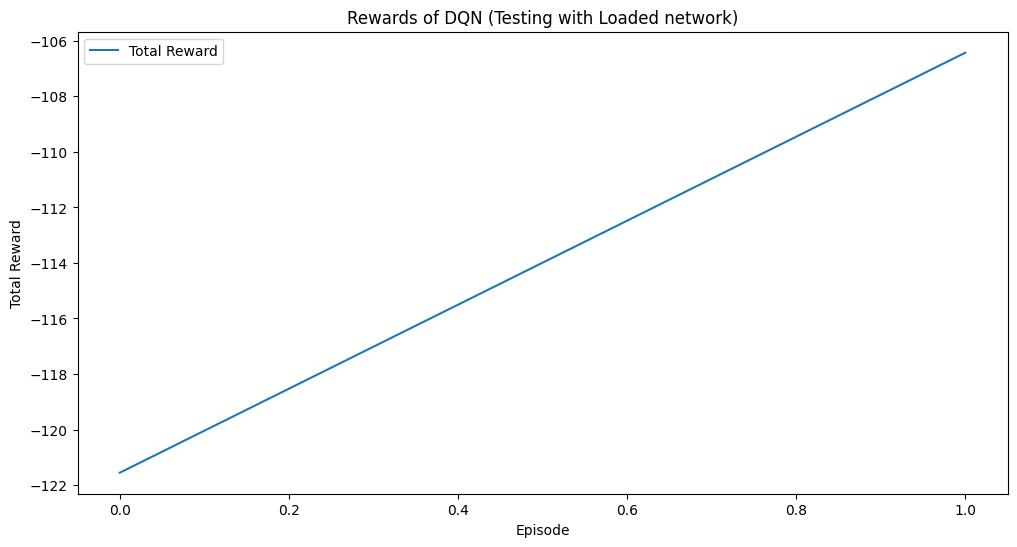

In [ ]:
import torch
import gymnasium as gym
import numpy as np


# Definizione dell'ambiente
ENV = "BipedalWalker-v3"
DEVICE = torch.device("cuda" if torch.cuda.is_available() else "cpu")
EPISODES = 100
NORMALIZE = True
REWARD_THRESHOLD = -1000
STEPS_THRESHOLD = 10000

class Normalizer:
    def __init__(self, num_inputs):
        self.mean = np.zeros(num_inputs)
        self.m2 = np.zeros(num_inputs)
        self.count = 0

    def update(self, x):
        self.count += 1
        old_mean = self.mean.copy()
        self.mean += (x - self.mean) / self.count
        self.m2 += (x - old_mean) * (x - self.mean)

    def normalize(self, x):
        eps = 1e-10
        mean = torch.tensor(self.mean).float().to(DEVICE)
        if self.count > 1:
            variance = self.m2 / (self.count - 1)
        else:
            variance = np.zeros_like(self.m2)
        stdev = torch.tensor(np.sqrt(variance) + eps).float().to(DEVICE)
        x = (x - mean) / (stdev)
        return x


action_buckets = 11

# Carica i parametri del modello salvato
model_params = torch.load('dqn_model.pth', map_location=DEVICE)

# Crea l'ambiente
env = gym.make(ENV, render_mode = 'human')
state_dim = env.observation_space.shape[0]
action_dim = env.action_space.shape[0]

# Crea il modello e carica i parametri
model = QNetwork(state_dim, action_buckets ** action_dim).to(DEVICE)
model.load_state_dict(model_params)
model.eval()  # Imposta il modello in modalità valutazione

def test_DQN(dqn, env, episodes = EPISODES, normalize = NORMALIZE, reward_threshold = REWARD_THRESHOLD, steps_threshold = STEPS_THRESHOLD):
    rewards = []
    render_freq = 10
    if normalize:
        normalizer = Normalizer(env.observation_space.shape[0])
    for i in range(episodes):
        observation = env.reset()[0]
        if normalize:
            normalizer.update(observation)
        total_reward = 0
        done = False
        steps = 0

        while not done and total_reward > reward_threshold and steps < steps_threshold:
            with torch.no_grad():  # Disabilita il calcolo dei gradienti durante l'inferenza
                # Preprocessa l'osservazione se necessario
                state = torch.tensor(observation).float().to(DEVICE)
                if normalize:
                    state = normalizer.normalize(state)
                q_values = dqn(state)

                # Scegli l'azione con il massimo Q-value
                flat_discrete_action = q_values.argmax().item()
                discrete_action = np.array(np.unravel_index(flat_discrete_action, [action_buckets] * env.action_space.shape[0]))
                action = (discrete_action / (action_buckets - 1)) * (env.action_space.high - env.action_space.low) + env.action_space.low

            # Esegui l'azione nell'ambiente
            next_observation, reward, done, _, _ = env.step(action)
            if normalize:
                normalizer.update(next_observation)
            total_reward += reward
            observation = next_observation

            # Visualizza l'ambiente (commenta questa linea se non vuoi visualizzare l'ambiente)
            if steps % render_freq == 0:
                env.render()
            steps += 1
        rewards.append(total_reward)

        print(f"Episode {i + 1}, Total Reward: {total_reward}")

    env.close()  # Assicurati di chiudere l'ambiente
    print("Testing completed.")
    return rewards

# Esegui il test
rewards = test_DQN(model, env)


plt.figure(figsize=(12, 6))
plt.plot(rewards, label='Total Reward')
plt.xlabel('Episode')
plt.ylabel('Total Reward')
plt.title(f'Rewards of DQN (Testing with Loaded network)')
plt.legend()
plt.savefig(f'Rewards DQN.png')


In [ ]:
import numpy as np
import torch
#test normalizer

class Normalizer:
    def __init__(self, num_inputs):
        self.mean = np.zeros(num_inputs)
        self.m2 = np.zeros(num_inputs)
        self.count = 0

    # Welford's online algorithm for update using unbiased variance
    # more info: https://en.wikipedia.org/wiki/Algorithms_for_calculating_variance#Welford's_online_algorithm
    def update(self, x):
        self.count += 1
        old_mean = self.mean.copy()
        self.mean += (x - self.mean) / self.count
        self.m2 += (x - old_mean) * (x - self.mean)

    def normalize(self, x):
        print("Input:", x)
        eps = 1e-10
        mean = torch.tensor(self.mean).float().to(DEVICE)
        if self.count > 1:
            variance = self.m2 / (self.count - 1)
        else:
            variance = np.zeros_like(self.m2)
        stdev = torch.tensor(np.sqrt(variance) + eps).float().to(DEVICE)
        x = (x - mean) / (stdev)
        print("Normalized:", x)
        print("Mean:", mean)
        print("Std Dev:", stdev)
        return x

# Esempio di utilizzo
DEVICE = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

# Creare un'istanza di Normalizer con 24 dimensioni
normalizer = Normalizer(num_inputs=24)

# Generare alcuni campioni casuali e aggiornare il normalizzatore
for _ in range(10):
    data = np.random.randn(24)
    normalizer.update(data)
    data = torch.tensor(data).float().to(DEVICE)
    normalized_data = normalizer.normalize(data)

# Generare un nuovo campione casuale e normalizzarlo
test_data = torch.tensor(np.random.randn(24)).float().to(DEVICE)
normalized_data = normalizer.normalize(test_data)
print(normalized_data)


Input: tensor([ 0.3365,  0.1489, -1.8537,  0.4362,  0.7138, -0.9746, -1.4749,  0.4005,
        -0.7925, -0.0024,  0.7936, -0.4299, -0.1247, -1.0604, -1.9603, -0.1094,
         0.4510, -0.8595,  1.3778, -0.4465, -1.4240, -0.9472,  0.4821,  0.0774],
       device='cuda:0')
Normalized: tensor([0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.],
       device='cuda:0')
Mean: tensor([ 0.3365,  0.1489, -1.8537,  0.4362,  0.7138, -0.9746, -1.4749,  0.4005,
        -0.7925, -0.0024,  0.7936, -0.4299, -0.1247, -1.0604, -1.9603, -0.1094,
         0.4510, -0.8595,  1.3778, -0.4465, -1.4240, -0.9472,  0.4821,  0.0774],
       device='cuda:0')
Std Dev: tensor([1.0000e-10, 1.0000e-10, 1.0000e-10, 1.0000e-10, 1.0000e-10, 1.0000e-10,
        1.0000e-10, 1.0000e-10, 1.0000e-10, 1.0000e-10, 1.0000e-10, 1.0000e-10,
        1.0000e-10, 1.0000e-10, 1.0000e-10, 1.0000e-10, 1.0000e-10, 1.0000e-10,
        1.0000e-10, 1.0000e-10, 1.0000e-10, 1.0000e-10, 1.0000e-10,

In [ ]:
import numpy as np

# Supponendo che discrete_action sia l'indice singolo che rappresenta l'azione discreta
discrete_action = 123  # Esempio di indice

# Calcoliamo gli indici per ogni dimensione delle azioni
action_indices = np.unravel_index(discrete_action, [action_buckets] * env.action_space.shape[0])

# Stampa degli indici per debug
print("Indices for each action dimension:", action_indices)

# Se vuoi convertire questi indici in una tupla di azione discreta
discrete_action_tuple = tuple(action_indices)

# Stampa dell'azione discreta come tupla
print("Discrete action as tuple:", discrete_action_tuple)


Indices for each action dimension: (0, 1, 0, 2)
Discrete action as tuple: (0, 1, 0, 2)
